# Projet Steganographie texte dans une image rbv

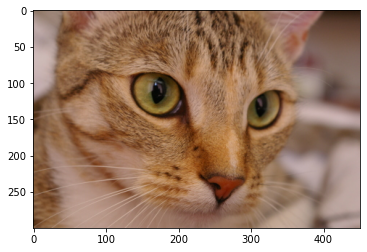

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage

img = skimage.data.chelsea()
plt.imshow(img)
plt.show()

In [2]:
print("Y :", img.shape[0])
print("X :", img.shape[1])
print("Image en couleur donc", img.shape[2],"pixels par pixel")

print("\nNombre de pixels total que l'on peut coder:", img.shape[0]*img.shape[1]*img.shape[2])

Y : 300
X : 451
Image en couleur donc 3 pixels par pixel

Nombre de pixels total que l'on peut coder: 405900


## Etape 1 : Transformer chaque caractère en code ASCII puis binaire

In [7]:
message = "Thalassius vero ea tempestate praefectus praetorio praesens ipse quoque adrogantis ingenii, considerans incitationem eius ad multorum augeri discrimina, non maturitate vel consiliis mitigabat, ut aliquotiens celsae potestates iras principum molliverunt, sed adversando iurgandoque cum parum congrueret, eum ad rabiem potius evibrabat, Augustum actus eius exaggerando creberrime docens, idque, incertum qua mente, ne lateret adfectans. quibus mox Caesar acrius efferatus, velut contumaciae quoddam vexillum altius erigens, sine respectu salutis alienae vel suae ad vertenda opposita instar rapidi fluminis irrevocabili impetu ferebatur.Postremo ad id indignitatis est ventum, ut cum peregrini ob formidatam haut ita dudum alimentorum inopiam pellerentur ab urbe praecipites, sectatoribus disciplinarum liberalium inpendio paucis sine respiratione ulla extrusis, tenerentur minimarum adseclae veri, quique id simularunt ad tempus, et tria milia saltatricum ne interpellata quidem cum choris totidemque remanerent magistris.Horum adventum praedocti speculationibus fidis rectores militum tessera data sollemni armatos omnes celeri eduxere procursu et agiliter praeterito Calycadni fluminis ponte, cuius undarum magnitudo murorum adluit turres, in speciem locavere pugnandi. neque tamen exiluit quisquam nec permissus est congredi. formidabatur enim flagrans vesania manus et superior numero et ruitura sine respectu salutis in ferrum."

In [8]:
def string_to_binaire(message):
    liste_de_binaire = []
    
    # On ajoute un mot-code STOP à la fin du message pour simplifier le décodage
    # Hint : STOP s'écrit en binaire : 01010011, 01010100, 01001111, 01010000
    STOP = ['01010011', '01010100', '01001111', '01010000']
    
    for lettre in message :
        lettre_asci = ord(lettre)
        lettre_binaire = bin(lettre_asci)
        lettre_binaire = lettre_binaire[2:].zfill(8)
        liste_de_binaire.append(lettre_binaire)
        
    return liste_de_binaire + STOP

liste_binaire = string_to_binaire(message)
    
def ligne_binaire(liste):
    ''' 
    ligne binaire est une fonction permettant d'obtenir à partir d'une liste de suite d'octet,
    une seule suite d'octet encodant l'intégralité du message 
    
    liste : le message sous forme de liste de caractères encodé en binaire 
    
    retourne le message écrit sous forme binaire avec des caractères encodés sur 8 bits '''
    chiffres = ""
    for i in liste:
        chiffres += i
        
    return chiffres

message_bin_flat = ligne_binaire(liste_binaire)

On remplace le dernier bit de chaque couleur de chaque pixel par les bits qu'on veut cacher

### A modifier ! Ajouter la clé !

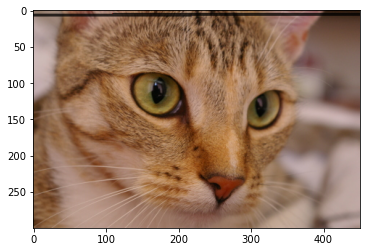

In [9]:
def encoder_image(img, chiffres, lsb, *cle):
    # Tableau de string : va contenir les infos en binaire
    img_bin = np.chararray((img.shape[0], img.shape[1], img.shape[2]), itemsize=8)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                img_bin[i,j,k] = bin(img[i,j,k])[2:].zfill(8)
                
    # mettre au bon format le tableau de string
    img_bin = img_bin.decode("utf-8")
    print(img_bin)
    
    # On flatten l'image pour itérer plus facilement
    img_bin_flat = img_bin.flatten()
    img_encoded_bin = img_bin_flat.copy()
        
    for i in range(len(chiffres)):
        img_encoded_bin[i] = img_encoded_bin[i][:8-lsb] + chiffres[0:lsb]
        chiffres = chiffres[lsb:] #ici problème probable
    print()    
    img_encoded_bin = np.reshape(img_encoded_bin, img_bin.shape)
    img_encoded = img.copy()
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            for k in range(img.shape[2]):
                img_encoded[i,j,k] = int(img_encoded_bin[i,j,k],2)
        
    return img_encoded

img_encoded = encoder_image(img, message_bin_flat, 2)
plt.imshow(img_encoded)
plt.show()

In [24]:
img_encoded[5]

array([[39, 33, 31],
       [38, 32, 30],
       [38, 32, 29],
       ...,
       [13,  9,  5],
       [13,  9,  5],
       [14,  8,  5]], dtype=uint8)

## Etape 4 : Decoder le message

In [51]:
cle = np.random.randint(2, size=(img.shape[0], img.shape[1]))
cle *= 2

In [52]:
def deviner_lsb(cle):
    modalites = np.unique(cle)
    return modalites[1]

In [53]:
def find_secret_message_bin(image_bin_flat, lsb):
    i = 1
    message_encoded_bin = []
    bits = ""
    motcode = ""
    STOP = ['01010011', '01010100', '01001111', '01010000']
    
    while(True):
        # On récupère les derniers bits de chaque rvb de chaque pixel
        bits += image_bin_flat[i-1][8-lsb:]

        if (len(bits) == 8):
            message_encoded_bin.append(bits)
            
            # A partir de 4 lettres, on peut penser qu'il y a le mot-code STOP
            # On récupère donc ces 4 dernières lettres et on regarde si c'est STOP
            # Si c'est le cas : on arrête la recherche de binaire
            if(len(message_encoded_bin)>=4):
                maximum = len(message_encoded_bin)
                motcode = message_encoded_bin[maximum-4:maximum]
                
                # On enlève les 4 lettres binaires à la fin du message recupérée
                if(motcode == STOP):
                    message_encoded_bin = message_encoded_bin[:maximum-4]
                    break;
            
            bits = ""
            
        i += 1
    
    return message_encoded_bin

def find_secret_message(image_encoded, cle):
    lsb = deviner_lsb(cle)

    # on la met en binaire
    lig, col, couleur =  image_encoded.shape
    image_bin = np.chararray((lig, col, couleur), itemsize=8)

    for i in range(lig):
        for j in range(col):
            for k in range(couleur):
                image_bin[i,j,k] = bin(image_encoded[i,j,k])[2:].zfill(8)

    image_bin = image_bin.decode("utf-8")
    image_bin_flat = image_bin.flatten()
    
    # Méthode pour trouver le message binaire en utilisant le mot-code STOP
    message_encoded_bin = find_secret_message_bin(image_bin_flat, lsb)
    
    # On transforme tout en ASCII
    message_encoded_ascii = [None]*len(message_encoded_bin)

    for i in range(len(message_encoded_bin)):
        message_encoded_ascii[i] = chr(int(message_encoded_bin[i],2))

    return (''.join(message_encoded_ascii))

secret_message = find_secret_message(img_encoded, cle)
print(secret_message)

Une fois qu'on aura trouvé cette méthode nulle de clé ca sera fini


## Comparons visuellement les deux images

In [10]:
def histogramme(image, titre, num):
    plt.subplot(1,2,num)
    plt.hist(image.ravel(), bins = range(0,256), color = "gray")
    plt.xlabel('Valeurs')
    plt.ylabel('Nombre de pixels')
    plt.title(titre)

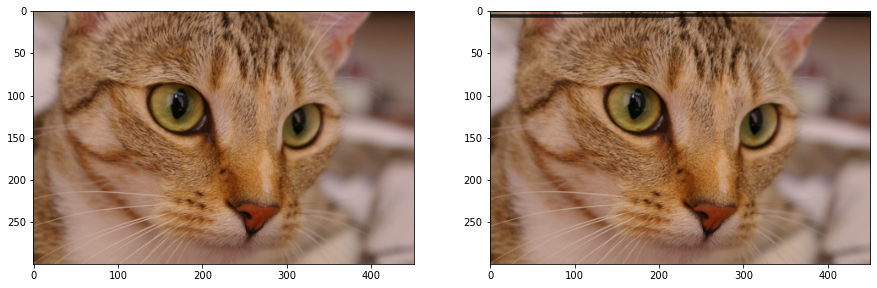

In [11]:
plt.figure(figsize = (15, 15))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(img_encoded)
plt.show()

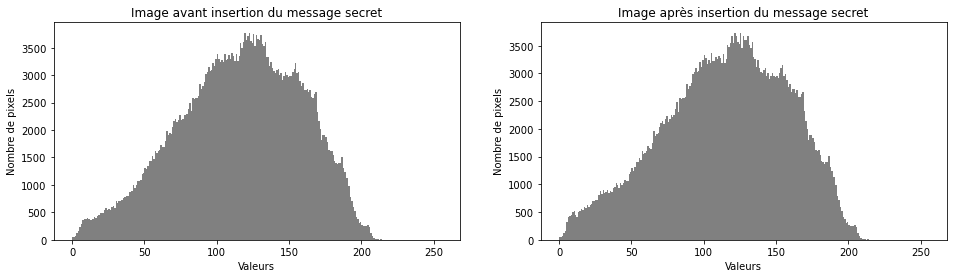

In [12]:
plt.figure(figsize=(16,4))
histogramme(img, "Image avant insertion du message secret", 1)
histogramme(img_encoded, "Image après insertion du message secret", 2)

## Petits tests pour essayer de générer une clé pseudo aléatoire

In [174]:
def generate_cle(coef, img, message):
    nbr_pixels = img.shape[0]*img.shape[1]*img.shape[2]
    longueur = len(message)
    
    random.seed(coef)
    return [int(random.random()*nbr_pixels-1) for _ in range(longueur)]

In [175]:
print(generate_cle(23, img, message))

[375402, 385039, 362238, 33913, 240303, 171999, 215162, 52889, 77931, 180452, 89719, 184697, 10052, 34815, 288192, 170984, 208078, 298015, 145716, 23361, 317861, 239125, 267046, 252060, 394021, 147257, 308397, 149648, 232193, 268109, 127611, 34800, 192423, 291401, 239728, 181620, 260741, 73885, 72469, 131273, 331163, 79397, 46394, 40023, 15802, 111851, 232508, 333107, 134273, 150042, 117095, 123713, 315620, 222836, 104892, 43482, 318148, 287029, 336314, 96614, 221409, 372917, 240575, 383764, 67890, 395755]


Ici on a pleins de nombres (plus précisement on a le nombre de lettres du message), qui correspondent aux pixels de l'image que nous allons coder. La clé donné sera 23 et la personne pourra lire le message secret.

**Rappel** : 

- Longueur Y : 300
- Longueur X : 451
- Image en couleur donc 3 pixels par pixel

Nombre de pixels total que l'on peut coder : 405900

In [182]:
img.flatten().shape

(405900,)